# Предсказание ребер в графе

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

# Чтение данных

In [2]:
df = pd.read_csv('edges.csv', names=['i', 'j'])

df.drop(labels=0, axis=0, inplace=True)
df = df.astype(int)

In [3]:
print(df.shape)
df.head()

(34834, 2)


,i,j
1,2106,1
2,2132,1
3,3516,1
4,3881,1
5,10872,1


In [4]:
df.tail()

,i,j
34830,7950,11548
34831,7950,11549
34832,7950,11550
34833,7950,11551
34834,7950,11552


# Первичный анализ графа

In [5]:
g = nx.Graph()
g.add_edges_from(df.values)

### Вершины

In [6]:
print('В датафрейме содержится {} различных вершин графа.'.format(len(np.unique(df.values))))
print('В графе содержится {} вершин.'.format(g.number_of_nodes()))

В датафрейме содержится 8959 различных вершин графа.
В графе содержится 8959 вершин.


In [7]:
values = np.ravel(df.values)
missed_nodes = [n for n in range(values.min(), values.max() + 1) if n not in values]
print('В датафрейме между вершинами графа {} и {} пропущено {} вершины.'.
      format(values.min(), values.max() + 1, len(missed_nodes)))

missed_nodes = [n for n in range(min(g.nodes), max(g.nodes) + 1) if n not in g]
print('В графе между вершинами {} и {} пропущено {} вершины.'.
      format(min(g.nodes), max(g.nodes) + 1, len(missed_nodes)))

В датафрейме между вершинами графа 1 и 11553 пропущено 2593 вершины.
В графе между вершинами 1 и 11553 пропущено 2593 вершины.


##### Все вершины из датафрейма попали в граф.

### Рёбра

In [8]:
print('В датафрейме содержится {} рёбер графа.'.format(len(df)))
print('В графе содержится {} рёбер.'.format(g.number_of_edges()))

В датафрейме содержится 34834 рёбер графа.
В графе содержится 34729 рёбер.


##### В чем причина расхождения?
Поскольку граф - неориентированный, ребро (i, j) эквивалентно ребру (j, i). Создадим список всех рёбер графа из датафрейма таким образом, чтобы первая компонента была не больше второй. После этого оставим в данном списке только уникальные рёбра.

In [9]:
edges_from_df = [tuple(sorted(edge)) for edge in df.values]
print('В датафрейме содержится {} уникальных рёбер графа.'.format(len(set(edges_from_df))))

В датафрейме содержится 34729 уникальных рёбер графа.


##### Таким образом, причина расхождения заключается в том, что в датафрейме дублируются некоторые рёбра.
##### Все рёбра из датафрейма попали в граф ровно один раз.

### Петли

In [10]:
self_loop_nodes = [i for (i, j) in df.values if i == j]
print('В датафрейме содержится {} петель графа.'.format(len(self_loop_nodes)))
print('Петли в датафрейме находятся в вершинах:\n', self_loop_nodes)

self_loop_nodes = [n for n in range(min(g.nodes), max(g.nodes) + 1)
                                if n in g and n in g.neighbors(n)]
print('\nВ графе содержится {} петель.'.format(len(self_loop_nodes)))
print('Петли в графе находятся в вершинах:\n', self_loop_nodes)

В датафрейме содержится 15 петель графа.
Петли в датафрейме находятся в вершинах:
 [1075, 1107, 1355, 1652, 2023, 2346, 2423, 3159, 3388, 4364, 6647, 7973, 7986, 8789, 9524]

В графе содержится 15 петель.
Петли в графе находятся в вершинах:
 [1075, 1107, 1355, 1652, 2023, 2346, 2423, 3159, 3388, 4364, 6647, 7973, 7986, 8789, 9524]


##### Все петли из датафрейма попали в граф.

### Удаление петель

In [11]:
for n in range(min(g.nodes), max(g.nodes) + 1):
    if n in g and n in g.neighbors(n):
        g.remove_edge(n, n)

self_loop_nodes = [n for n in range(min(g.nodes), max(g.nodes) + 1)
                                if n in g and n in g.neighbors(n)]
print('\nВ графе содержится {} петель.'.format(len(self_loop_nodes)))


В графе содержится 0 петель.


##### В графе не осталось петель.

# Создание полной выборки

### Создание датафрейма существующих рёбер

In [12]:
edges_df = pd.DataFrame(sorted([tuple(sorted(edge)) for edge in list(g.edges)]),
                       columns=['node1', 'node2'])
edges_df['edge'] = [1] * len(edges_df)

In [13]:
print(edges_df.shape)
edges_df.head()

(34714, 3)


,node1,node2,edge
0,1,2,1
1,1,3,1
2,1,4,1
3,1,5,1
4,1,6,1


### Генерирование несуществующих рёбер

Сгенерируем список несуществующих рёбер, равный по размеру количеству настоящих рёбер графа.

In [14]:
# def nonexistent_edges_generator(graph):
#     g_min, g_max = min(graph.nodes), max(graph.nodes)
#     i, j = 0, 0
    
#     while(i not in graph.nodes or j not in graph.nodes or
#                                           (i, j) in graph.edges() or i ==j):
#         i, j = np.random.randint(low=g_min, high=(g_max + 1), size=2)
    
#     return i, j

In [15]:
# nonexistent_edges = [nonexistent_edges_generator(g) for _ in range(len(edges_df))]

In [16]:
# nonexistent_edges[:5]

Сохраним список несуществующих рёбер в файл, и в дальнейшем для воспроизводимости будет использовать именно его.

In [17]:
# pd.DataFrame(nonexistent_edges).to_csv('nonexistent_edges.csv',
#                                        header=['i', 'j'], index=False)

### Обработка несуществующих рёбер

Считаем из файла список несуществующих рёбер.

In [18]:
nonexistent_edges_df = pd.read_csv('nonexistent_edges.csv', names=['i', 'j'])

nonexistent_edges_df.drop(labels=0, axis=0, inplace=True)
nonexistent_edges_df = nonexistent_edges_df.astype(int)

In [19]:
print(nonexistent_edges_df.shape)
nonexistent_edges_df.head()

(34714, 2)


,i,j
1,8128,4539
2,7691,7753
3,1352,10319
4,2455,2543
5,4541,2052


In [20]:
nonexistent_edges_df.tail()

,i,j
34710,3608,5646
34711,638,2446
34712,4032,9303
34713,10515,9323
34714,4100,1782


Проверим, что все вершины, связанные с несуществующими рёбрами присутствуют в графе, а самих несуществующих рёбер в графе нет, и они не являются петлями. 

In [21]:
for (i, j) in nonexistent_edges_df.values:
    if i not in g.nodes() or j not in g.nodes() or (i, j) in g.edges() or i == j:
        print('Ошибка в ребре', [i, j])

Ошибок в рёбрах нет.

### Создание датафрейма несуществующих рёбер.

In [22]:
nonexistent_edges_df = pd.DataFrame(sorted([tuple(sorted(edge))
            for edge in nonexistent_edges_df.values]), columns=['node1', 'node2'])
nonexistent_edges_df['edge'] = [0] * len(nonexistent_edges_df)

In [23]:
print(nonexistent_edges_df.shape)
nonexistent_edges_df.head()

(34714, 3)


,node1,node2,edge
0,1,72,0
1,1,1549,0
2,1,2911,0
3,1,3369,0
4,1,4251,0


### Создание полного датафрейма

In [24]:
full_df = pd.concat((edges_df, nonexistent_edges_df), axis=0, ignore_index=True)

X = full_df.drop(['edge'], axis=1, inplace=False).copy()
y = full_df['edge'].copy()

X.shape, y.shape

((69428, 2), (69428,))

# Генерирование признаков

### Разбиение выборки на обучающую и тестовую в соотношении 80% на 20%

In [25]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42, shuffle=True)

train_indices = X_train.index.values
test_indices = X_test.index.values
train_indices.shape, test_indices.shape

((55542,), (13886,))

### Удаление рёбер тестовой выборки из графа

In [26]:
print('В графе было {} рёбер.'.format(g.number_of_edges()))

g.remove_edges_from(X.iloc[test_indices, :].values)
print('В графе осталось {} рёбер.'.format(g.number_of_edges()))

В графе было 34714 рёбер.
В графе осталось 27775 рёбер.


### Количество общих соседей

In [27]:
X['n_common_neighbors'] = X.apply(lambda row:
            len(tuple(nx.common_neighbors(g, row['node1'], row['node2']))), axis=1)

In [28]:
def feature_histogram(column_name, feature_name, x_range):
    plt.hist(X[column_name].values, x_range)
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')
    plt.title(feature_name + ' histogram')

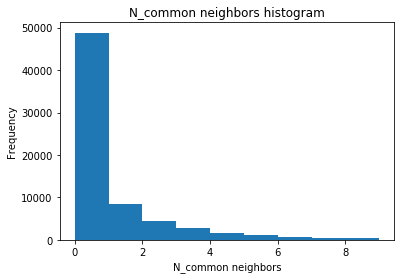

In [29]:
feature_histogram('n_common_neighbors', 'N_common neighbors', range(0, 10))

### Предпочтительность (произведение количества соседей двух вершин)

In [30]:
pref_atts = nx.preferential_attachment(g, X[['node1', 'node2']].values)

X['pref_att'] = [pref_att for u_, v_, pref_att in pref_atts]

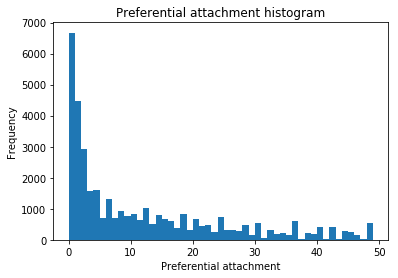

In [31]:
feature_histogram('pref_att', 'Preferential attachment', range(0, 50))

### Суммарный кластерный коэффициент

In [32]:
cluster_coefs = nx.clustering(g)

X['cluster_coef'] = X.apply(lambda row: cluster_coefs[row['node1']] +
                            cluster_coefs[row['node2']], axis=1)

### Коэффициент Жаккара

In [33]:
jacc_coefs = nx.jaccard_coefficient(g, X[['node1', 'node2']].values)

X['jacc_coef'] = [jacc for u_, v_, jacc in jacc_coefs]

### Коэффициент Адара

In [34]:
adar_coefs = nx.adamic_adar_index(g, X[['node1', 'node2']].values)

X['adar_coef'] = [adar for u_, v_, adar in adar_coefs]

### Коэффициент Resource allocation

In [35]:
ra_indices = nx.resource_allocation_index(g, X[['node1', 'node2']].values)

X['ra_index'] = [index for u_, v_, index in ra_indices]

### Суммарный Katz (Взвешенное число путей различной длины)

In [36]:
katz_dict = nx.katz_centrality(g, alpha=0.01)

X['katz_sum'] = X.apply(lambda row: katz_dict[row['node1']] +
                        katz_dict[row['node2']], axis=1)

### Суммарный PageRank

In [37]:
page_rank = nx.pagerank(g)

X['page_rank'] = X.apply(lambda row: page_rank[row['node1']] +
                         page_rank[row['node2']], axis=1)

# Построение модели

### Удаление номеров вершин

In [38]:
X.drop(['node1', 'node2'], axis=1, inplace=True)

### Разбиение выборки на обучающую и тестовую

In [39]:
X_train = X.iloc[train_indices]
y_train = y.iloc[train_indices]

X_test = X.iloc[test_indices]
y_test = y.iloc[test_indices]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55542, 8), (13886, 8), (55542,), (13886,))

In [40]:
X_train.head()

,n_common_neighbors,pref_att,cluster_coef,jacc_coef,adar_coef,ra_index,katz_sum,page_rank
33136,0,20,0.063158,0.000000,0.000000,0.000000,0.021564,0.000353
5955,1,238,0.238688,0.033333,0.352956,0.058824,0.023497,0.000438
15557,0,16,0.016667,0.000000,0.000000,0.000000,0.021267,0.000402
11270,2,1008,0.115873,0.032258,0.475442,0.031313,0.028110,0.000992
55323,0,3,0.000000,0.000000,0.000000,0.000000,0.019716,0.000087


In [41]:
X_test.head()

,n_common_neighbors,pref_att,cluster_coef,jacc_coef,adar_coef,ra_index,katz_sum,page_rank
58447,0,7,0.285714,0.000000,0.000000,0.000000,0.020265,0.000148
52139,0,17,0.095588,0.000000,0.000000,0.000000,0.022285,0.000318
6896,2,336,0.142857,0.057143,0.768103,0.150000,0.024071,0.000598
6268,3,464,0.264039,0.071429,0.799714,0.094385,0.026092,0.000597
20003,0,210,0.015321,0.000000,0.000000,0.000000,0.027646,0.001393


### Логистическая регрессия

In [42]:
param_grid = {'penalty': ['l1', 'l2'],
             'C': np.logspace(-4, 0, 5)}

lr = LogisticRegression(random_state=42)
grid_search = GridSearchCV(lr, param_grid=param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [43]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.938638158016
{'C': 0.01, 'penalty': 'l2'}


In [44]:
y_pred_probas = grid_search.best_estimator_.predict_proba(X_test)
print('roc_auc_score:', roc_auc_score(y_test, y_pred_probas[:, 1]))

roc_auc_score: 0.855438163736


In [46]:
y_pred = grid_search.best_estimator_.predict(X_test)

### Значение ROC AUC: 0.85544